In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1D-Xr7mRbev4pJlwU-id-OZRLS6XD7mKc')

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import torch
import jovian
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import QMNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader
print('all imported')

all imported


In [ ]:
# Hyperparmeters
batch_size = 128
learning_rate = 0.0001

# Other constants
input_size = 28*28
num_classes = 10

In [ ]:
jovian.reset()
jovian.log_hyperparams(batch_size=batch_size, learning_rate=learning_rate)

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Hyperparams logged.


## **Downloading Dataset and Dataloaders**

In [ ]:
# Download dataset
dataset = QMNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)

# Training validation & test dataset
train_ds, val_ds = random_split(dataset, [50000, 10000])
test_ds = QMNIST(root='data/', train=False, transform=transforms.ToTensor(), download = True)

# Dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)

Label: 5


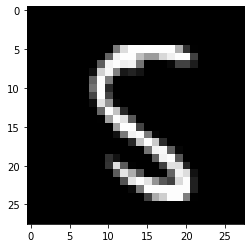

In [ ]:
image, label = train_ds[0]
plt.imshow(image[0], cmap='gray')
print('Label:', label)

# **Model**

In [ ]:
class QMnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = QMnistModel()

# **Training our Model**

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
evaluate(model, val_loader)

{'val_acc': 0.0849609375, 'val_loss': 2.325199604034424}

In [ ]:
history = fit(10, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9607, val_acc: 0.6156
Epoch [1], val_loss: 1.6904, val_acc: 0.7281
Epoch [2], val_loss: 1.4876, val_acc: 0.7621
Epoch [3], val_loss: 1.3344, val_acc: 0.7819
Epoch [4], val_loss: 1.2166, val_acc: 0.7944
Epoch [5], val_loss: 1.1240, val_acc: 0.8050
Epoch [6], val_loss: 1.0498, val_acc: 0.8114
Epoch [7], val_loss: 0.9893, val_acc: 0.8173
Epoch [8], val_loss: 0.9388, val_acc: 0.8248
Epoch [9], val_loss: 0.8962, val_acc: 0.8303


In [ ]:
history = fit(10, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.6727, val_acc: 0.8544
Epoch [1], val_loss: 0.5811, val_acc: 0.8627
Epoch [2], val_loss: 0.5294, val_acc: 0.8718
Epoch [3], val_loss: 0.4955, val_acc: 0.8768
Epoch [4], val_loss: 0.4709, val_acc: 0.8810
Epoch [5], val_loss: 0.4523, val_acc: 0.8874
Epoch [6], val_loss: 0.4376, val_acc: 0.8894
Epoch [7], val_loss: 0.4255, val_acc: 0.8904
Epoch [8], val_loss: 0.4157, val_acc: 0.8929
Epoch [9], val_loss: 0.4070, val_acc: 0.8936


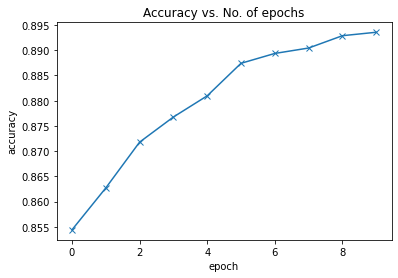

In [ ]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [ ]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_acc': 0.8906139731407166, 'val_loss': 0.4056866466999054}

In [ ]:
jovian.log_metrics(test_acc=result['val_acc'], test_loss=result['val_loss'])

[jovian] Metrics logged.


# **Prediction**

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 2 , Predicted: 2


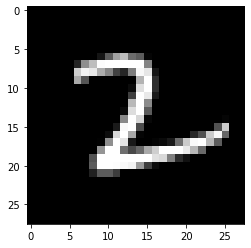

In [ ]:
img, label = test_ds[919]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 1 , Predicted: 3


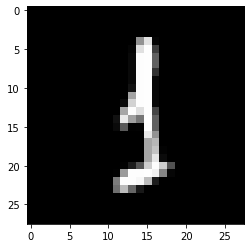

In [ ]:
img, label = test_ds[900]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 4 , Predicted: 4


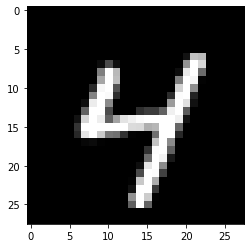

In [ ]:
img, label = test_ds[910]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 8 , Predicted: 5


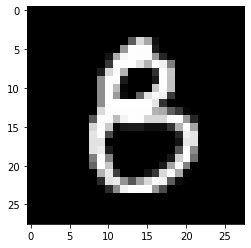

In [ ]:
img, label = test_ds[800]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 3 , Predicted: 3


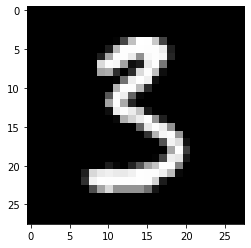

In [ ]:
img, label = test_ds[890]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [ ]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

In [ ]:
jovian.commit(project='mnist-logistic-minimal', environment=None, outputs=['mnist-logistic.pth'])